In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('display.max_colwidth', None)

# Config

In [4]:
# data path
data_path = './data/train.csv'

# Utils
Custom code snippets used in the code.

In [5]:
def get_encoded_feature_names(cat_cols, encoder):
    
    final_ft_names = []
    
    for ft_name, cats in zip(cat_cols, encoder.categories_):
        
        for cat in cats:
            final_ft_names.append(f"{ft_name}_{cat}")
            
    return final_ft_names

def get_all_feature_names(num_cols, cat_cols, encoder):
    return list(num_cols) + get_encoded_feature_names(cat_cols, encoder)

def get_feature_importances(model, feature_names):
    ft_imps = [(name, val) for name, val in zip(feature_names, model.coef_)]
    ft_imps = sorted(ft_imps, key=lambda x: abs(x[1]), reverse=True)
    return pd.DataFrame(ft_imps, columns=['feature', 'coef'])

# Get Column Desctiptions

In [6]:
with open('data_description.txt', 'r') as fp:
    # read logging
    logs = fp.readlines()

In [7]:
def get_descriptions(file_path = 'data_description.txt'):
    
    log_mapping = {}
    with open(file_path, 'r') as fp:
        # read logging
        logs = fp.readlines()
        logs = [log.strip() for log in logs if not \
                log.startswith('       ') and log.strip('\n\t').strip()]
        
        # get mapping
        log_mapping = dict(x.split(':') for x in logs)
        
    return log_mapping

log_mapping = get_descriptions()

# Load Data

In [8]:
data = pd.read_csv(data_path)
data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


# EDA

## Get Statistics

In [9]:
descp = data.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99], include='all').T.fillna('')
descp.insert(0, "description", [log_mapping.get(col, '') for col in descp.index])
descp

,description,count,unique,top,freq,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Id,,1460.0,,,,730.5,421.61,1,15.59,73.95,146.9,365.75,730.5,1095.25,1314.1,1387.05,1445.41,1460
MSSubClass,Identifies the type of dwelling involved in the sale.,1460.0,,,,56.8973,42.3006,20,20,20,20,20,50,70,120,160,190,190
MSZoning,Identifies the general zoning classification of the sale.,1460.0,5,RL,1151,,,,,,,,,,,,,
LotFrontage,Linear feet of street connected to property,1201.0,,,,70.05,24.2848,21,21,34,44,59,69,80,96,107,141,313
LotArea,Lot size in square feet,1460.0,,,,10516.8,9981.26,1300,1680,3311.7,5000,7553.5,9478.5,11601.5,14381.7,17401.2,37567.6,215245
Street,Type of road access to property,1460.0,2,Pave,1454,,,,,,,,,,,,,
Alley,Type of alley access to property,91.0,2,Grvl,50,,,,,,,,,,,,,
LotShape,General shape of property,1460.0,4,Reg,925,,,,,,,,,,,,,
LandContour,Flatness of the property,1460.0,4,Lvl,1311,,,,,,,,,,,,,
Utilities,Type of utilities available,1460.0,2,AllPub,1459,,,,,,,,,,,,,


### Observations on Null values

+ LotFrontage: Contain nulls, could be there is no connected road. So, can be filled with 0
+ Alley: Nulls which is due to, "NA 	No alley access"
+ Masonry veneer: Nulls could mean there is no Masonry veneer, i.e. external additional wall
+ MasVnrArea: Nulls mean no external additional wall
+ BsmtQual: Nulls mean no basement
+ BsmtExposure: Nulls mean no basement
+ BsmtFinSF1: Nulls mean no basement
+ BsmtFinType2: Nulls mean no basement
+ Electrical: Single null records, could be excluded or imputed with Majority value
+ FireplaceQu: Nulls could mean no Fireplace
+ GarageYrBlt: Nulls could mean no Garage exists
+ GarageFinish: Nulls could mean no Garage exists
+ GarageQual: Nulls could mean no Garage exists
+ GarageCond: Nulls could mean no Garage exists
+ PoolQC: Nulls could mean no Pool exists
+ Fence: Nulls could mean no Fence exists
+ MiscFeature: Features which does not exists in otherwise

### Observations on data types

+ MSSubClass: is categorical and not numeric
+ OverallQual: is ordinal, can be used as it is
+ OverallCond is ordinal, can be used as it is
+ YearBuilt, YearRemodAdd & YrSold: are ordinal and can be used as it is
+ MoSold: ordinal and can be used as it is

## Fix Nulls

In [10]:
data['LotFrontage'] = data['LotFrontage'].apply(lambda x: 0 if pd.isnull(x) else x)
data['Alley'] = data['Alley'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['MasVnrType'] = data['MasVnrType'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['MasVnrArea'] = data['MasVnrArea'].apply(lambda x: 0. if pd.isnull(x) else x)
data['BsmtQual'] = data['BsmtQual'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['BsmtExposure'] = data['BsmtExposure'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['BsmtFinSF1'] = data['BsmtFinSF1'].apply(lambda x: 0. if pd.isnull(x) else x)
data['BsmtFinType2'] = data['BsmtFinType2'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['FireplaceQu'] = data['FireplaceQu'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['GarageYrBlt'] = data['GarageYrBlt'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['GarageFinish'] = data['GarageFinish'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['GarageQual'] = data['GarageQual'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['GarageCond'] = data['GarageCond'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['PoolQC'] = data['PoolQC'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['Fence'] = data['Fence'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['MiscFeature'] = data['MiscFeature'].apply(lambda x: 'NA' if pd.isnull(x) else x)

data['BsmtCond'] = data['BsmtCond'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['BsmtFinType1'] = data['BsmtFinType1'].apply(lambda x: 'NA' if pd.isnull(x) else x)
data['GarageType'] = data['GarageType'].apply(lambda x: 'NA' if pd.isnull(x) else x)

## Change the datatype

In [11]:
data['MSSubClass'] = data['MSSubClass'].apply(str)

## Check Plots

In [12]:
def plot(data, y_col, cols=4, figsize=(30, 30), exclude_cols=[]):
    
    # get cols to plot
    cols2plot = set(data.columns) - set(exclude_cols + [y_col])
    
    # number of cols to plot
    num_cols = len(cols2plot)
    
    # number of rows
    rows = math.ceil(num_cols/cols)
    
    cols2plot = list(cols2plot)
    
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    if cols==1: axs = [[ax] for ax in axs]
    if rows==1: axs = [axs]
    
    for i in range(rows):
        
        for j in range(cols):
            
            if (i*cols + j) >= len(cols2plot):
                continue
            
            if str(data[cols2plot[i*cols + j]].dtype).startswith('int') or \
                str(data[cols2plot[i*cols + j]].dtype).startswith('float'):
                
                sns.scatterplot(x=cols2plot[i*cols + j], y=y_col, data=data, ax=axs[i][j])
                axs[i][j].set_xlabel(cols2plot[i*cols + j])
            
            if str(data[cols2plot[i*cols + j]].dtype).startswith('object'):
                
                sns.boxplot(x=cols2plot[i*cols + j], y=y_col, data=data, ax=axs[i][j])
                axs[i][j].set_xlabel(cols2plot[i*cols + j])
                if data[cols2plot[i*cols + j]].nunique() > 10:
                    axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(), rotation=90)
#                 else:
#                     print(cols2plot[i*cols + j])
            

    plt.show()

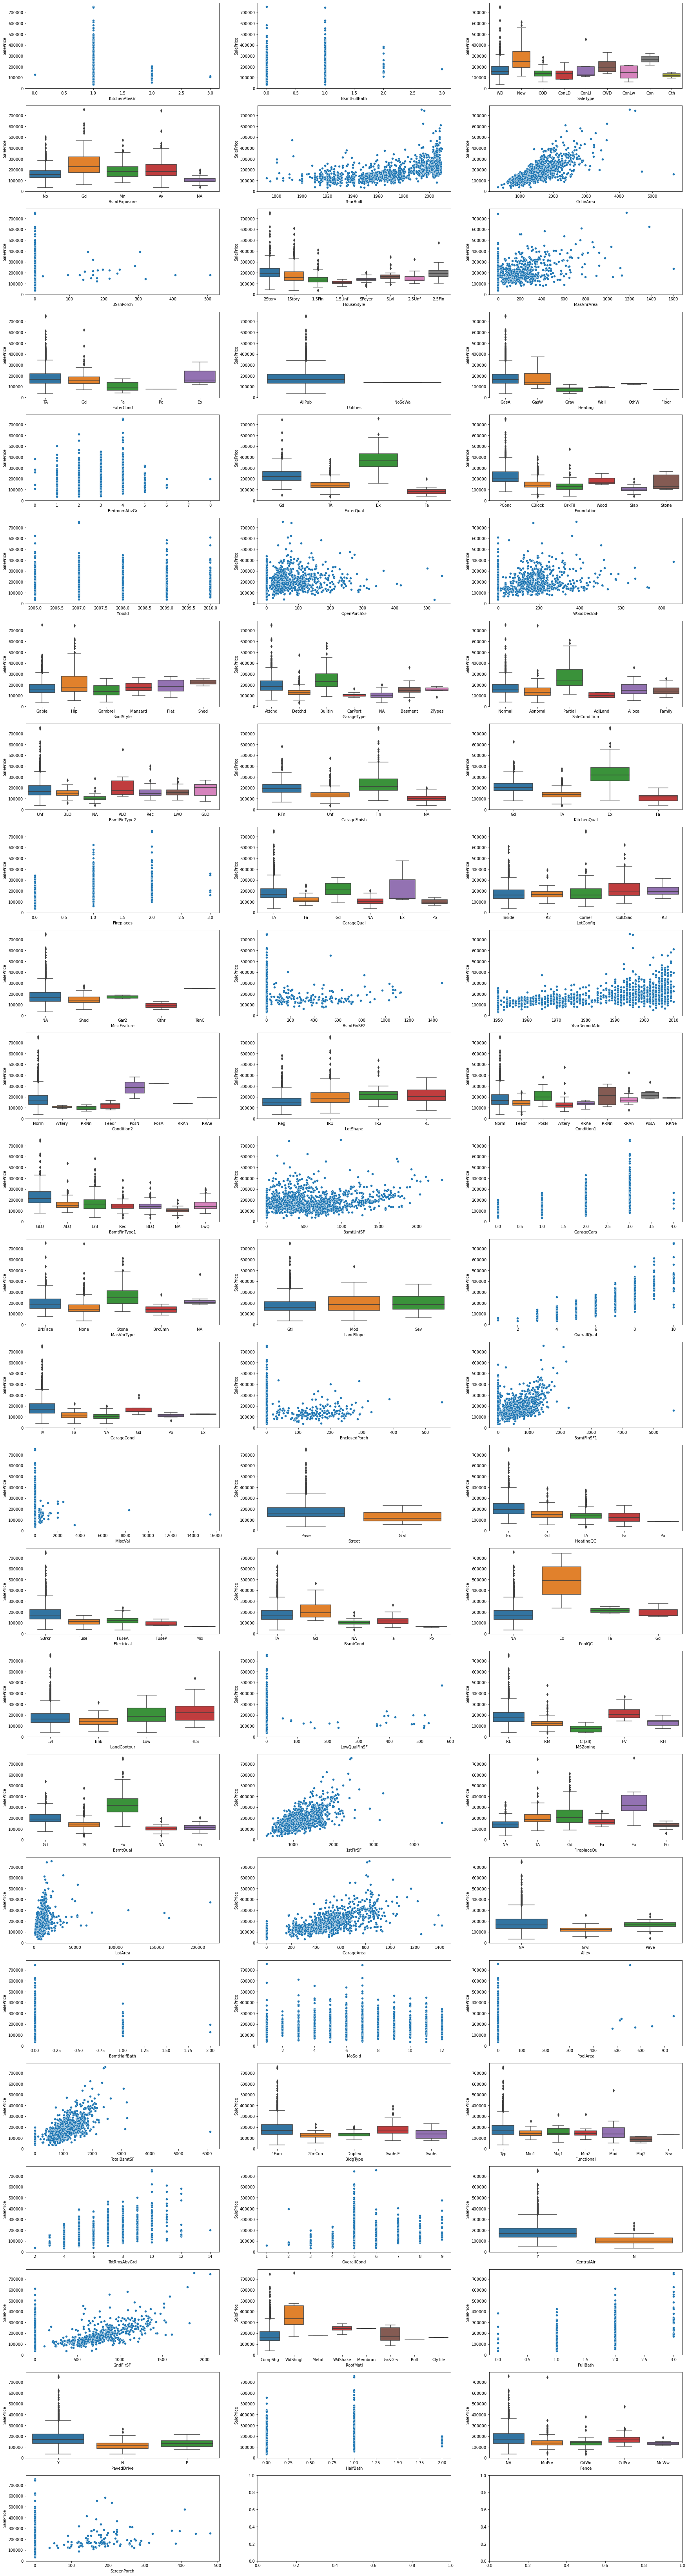

In [13]:
plot(data, y_col='SalePrice', cols=3, figsize=(30, 120), exclude_cols=['Id', 'Neighborhood', 'GarageYrBlt', 'Exterior2nd', 'Exterior1st', 'MSSubClass', 'LotFrontage'])

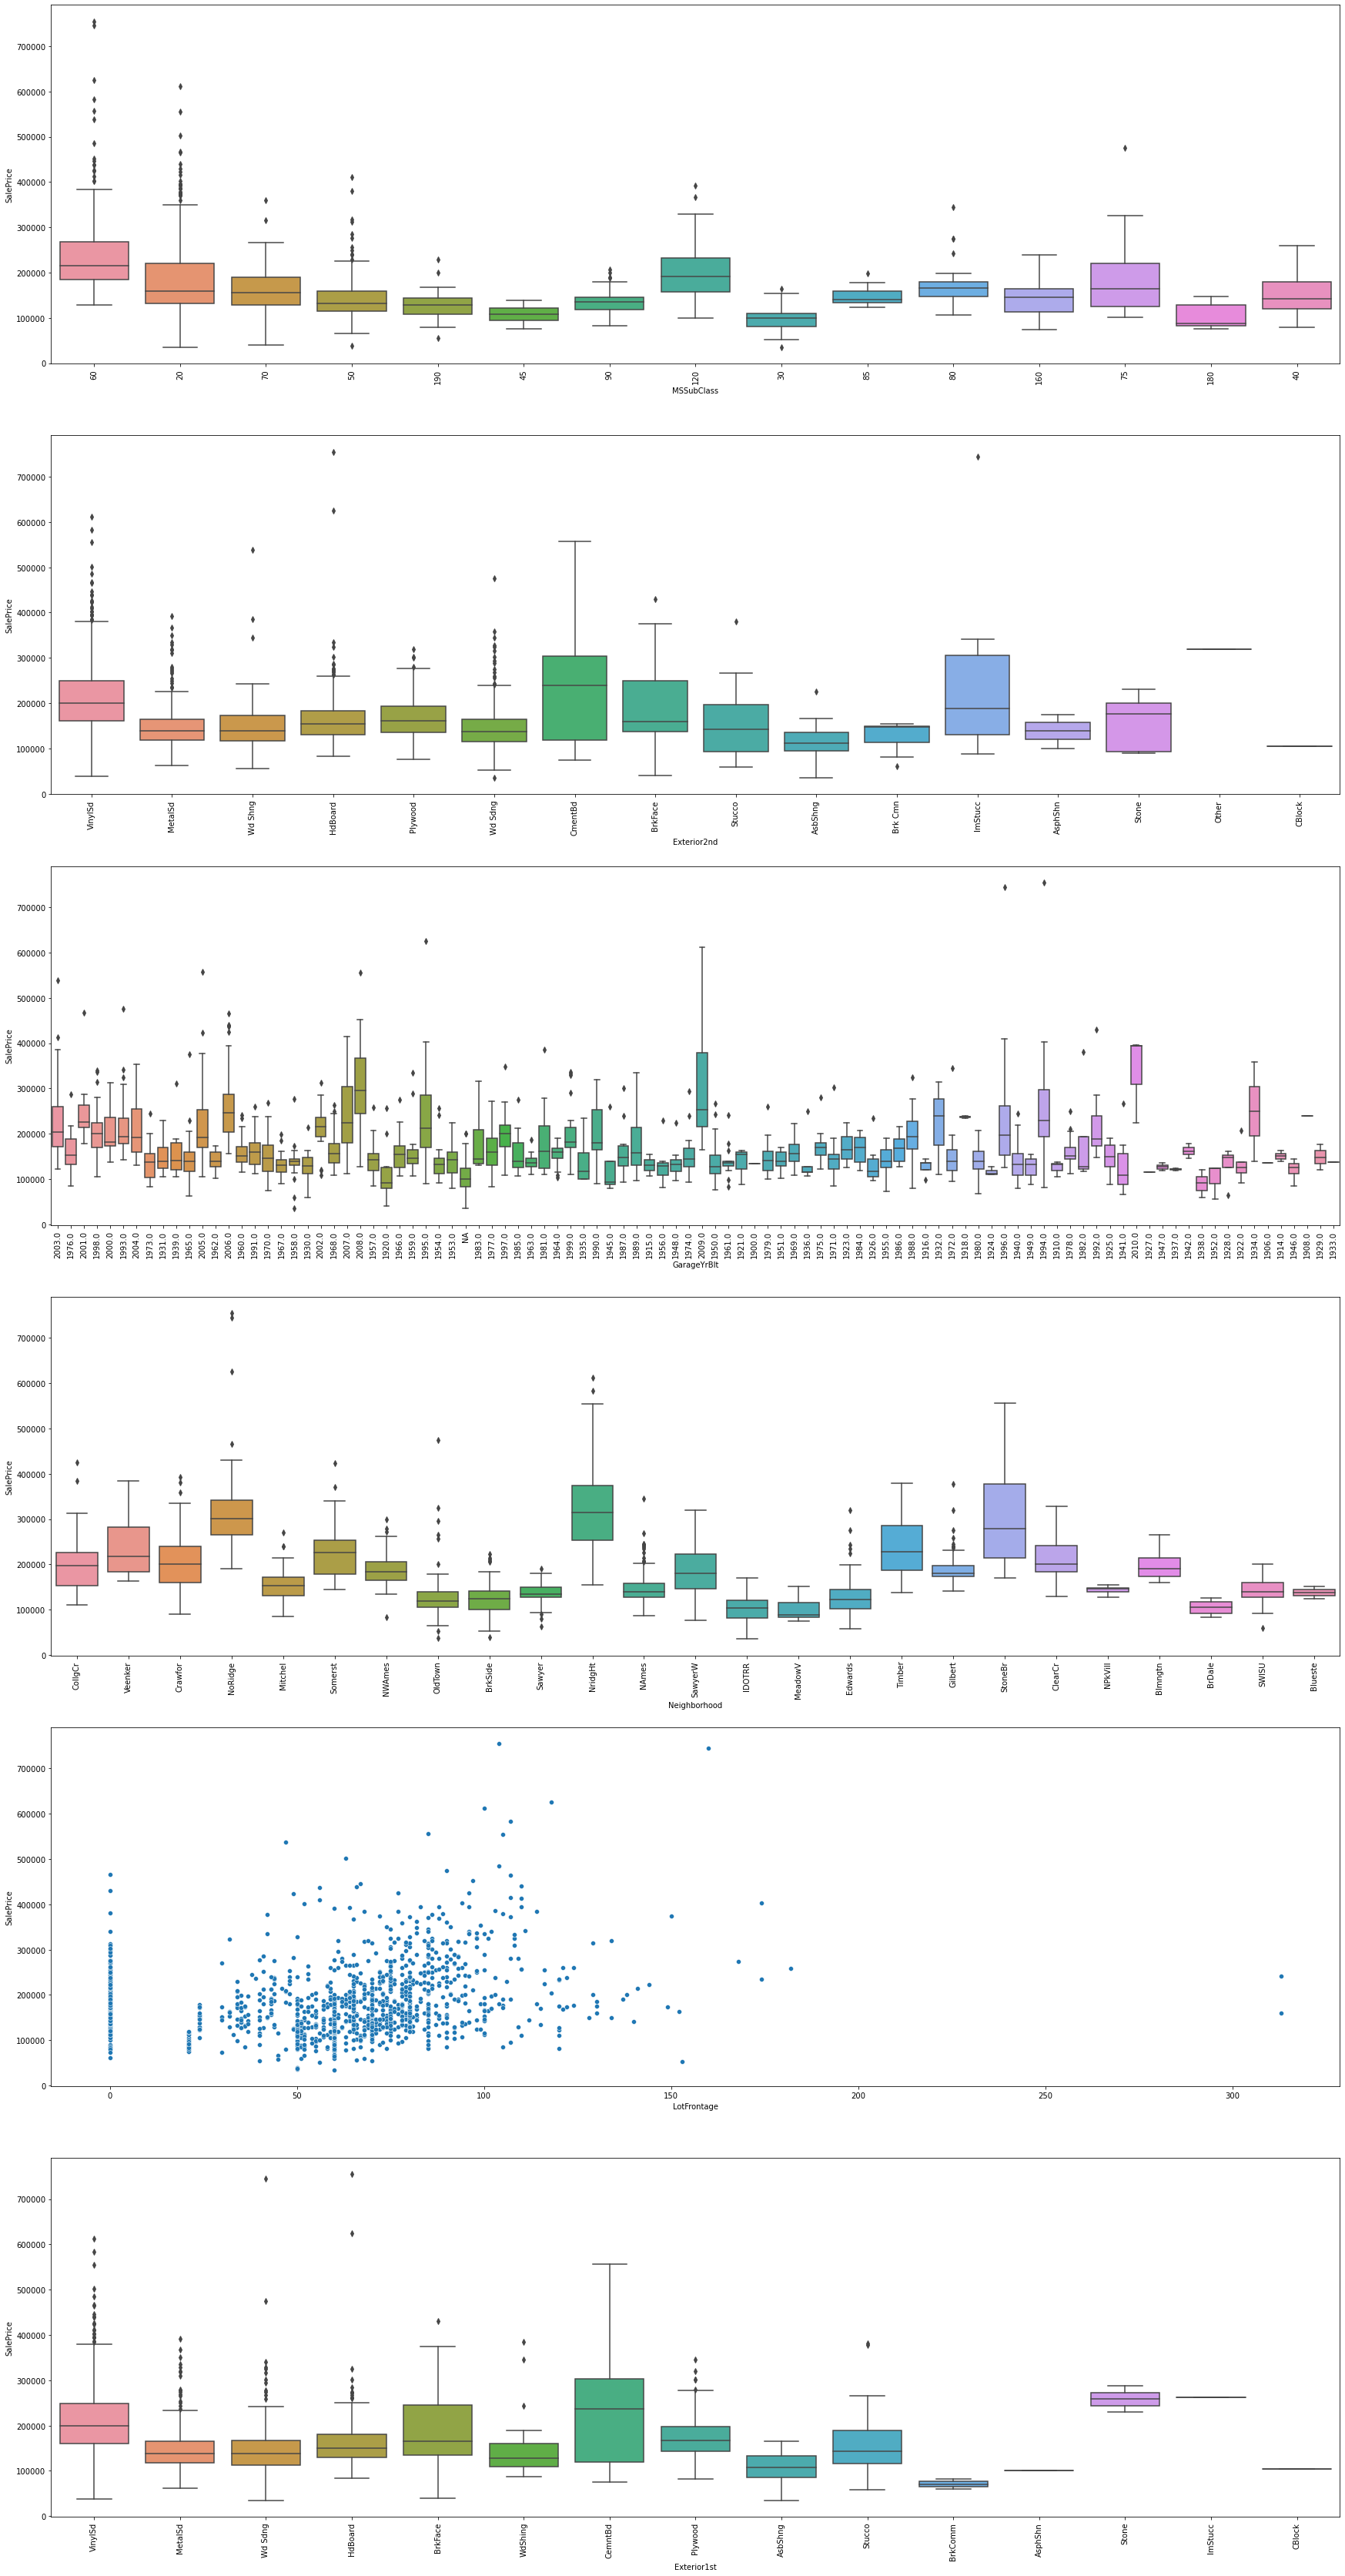

In [14]:
cols2select = ['Neighborhood', 'GarageYrBlt', 'Exterior2nd', 'Exterior1st', 'MSSubClass', 'LotFrontage', 'SalePrice']
plot(data[cols2select], y_col='SalePrice', cols=1, figsize=(30, 60), exclude_cols=['Id'])

## Observations from Plots

+ LandContour: leveled properties have more outliers/higher valued properties
+ PavedDrive: paved drives ("Y"), have higher prices
+ MiscVal: have very high values/outliers, any value above 4k can be excluded
+ 1stFlrSF: has linear relation with property price, and there are outliers above 4k
+ NoSeWa: has lower prices
+ PoolArea: very few properties have Pool
+ BsmtUnSF: do not have linear relationship, has more like log curve
+ BsmntQual: for "Excellent" quality, the prices are higher.
+ Newer properties have higher prices
+ HeatingQ: prices are higher when quality is better
+ Overallquality: higher the quality the higher are the prices
+ MsVnrTyp: Store typed Mason Vneer has higher prices
+ GrLvArea: with increasing area the prices increase as well
+ CentralAir: presence of Central Air lead to higher prices
+ RoofMatl: WdShngl has the higher price points 

In [15]:
data.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99, .999])

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
1%,15.590000,0.000000,1680.000000,3.000000,3.000000,1899.180000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,520.000000,0.000000,0.000000,692.180000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,61815.970000
5%,73.950000,0.000000,3311.700000,4.000000,4.000000,1916.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,519.300000,672.950000,0.000000,0.000000,848.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2006.000000,88000.000000
10%,146.900000,0.000000,5000.000000,5.000000,5.000000,1924.900000,1950.000000,0.000000,0.000000,0.000000,74.900000,636.900000,756.900000,0.000000,0.000000,912.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2006.000000,106475.000000
25%,365.750000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.

## Remove Outliers

In [16]:
# there are outliers in LotArea excluding them

print(f"Number of records before dropping outliers: {data.shape[0]:,}")

data = data[data['LotArea'] <= 40000]

print(f"Number of records after dropping outliers: {data.shape[0]:,}")

Number of records before dropping outliers: 1,460
Number of records after dropping outliers: 1,446


## Check Nulls

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1446 non-null   int64  
 1   MSSubClass     1446 non-null   object 
 2   MSZoning       1446 non-null   object 
 3   LotFrontage    1446 non-null   float64
 4   LotArea        1446 non-null   int64  
 5   Street         1446 non-null   object 
 6   Alley          1446 non-null   object 
 7   LotShape       1446 non-null   object 
 8   LandContour    1446 non-null   object 
 9   Utilities      1446 non-null   object 
 10  LotConfig      1446 non-null   object 
 11  LandSlope      1446 non-null   object 
 12  Neighborhood   1446 non-null   object 
 13  Condition1     1446 non-null   object 
 14  Condition2     1446 non-null   object 
 15  BldgType       1446 non-null   object 
 16  HouseStyle     1446 non-null   object 
 17  OverallQual    1446 non-null   int64  
 18  OverallC

In [18]:
print(f"Number of records before dropping nulls: {data.shape[0]:,}")

data = data.dropna()

print(f"Number of records after dropping nulls: {data.shape[0]:,}")

Number of records before dropping nulls: 1,446
Number of records after dropping nulls: 1,445


# Split the data into Train, Validation and Test

In [19]:
y = data['SalePrice']
X = data.copy()
del X['Id']
del X['SalePrice']

In [20]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

print(f"Number of numeric features: {len(numeric_cols)} & Number of categorical features: {len(cat_cols)}")

Number of numeric features: 34 & Number of categorical features: 45


In [21]:
# ensure data type
for col in numeric_cols: X[col] = X[col].astype(float)
    
for col in cat_cols: X[col] = X[col].astype(str)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=42)

print(f"Training sizes X-{X_train.shape}, y-{y_train.shape}")
# print(f"Validation sizes X-{X_val.shape}, y-{y_val.shape}")
print(f"Testing sizes X-{X_test.shape}, y-{y_test.shape}")

Training sizes X-(1300, 79), y-(1300,)
Testing sizes X-(145, 79), y-(145,)


# Prepare Pipeline

In [23]:
def get_model_pipeline(numeric_cols, cat_cols, model):
    numeric_transformer = Pipeline(steps=[
                            ('poly', PolynomialFeatures()),
                            ('scaler', StandardScaler())
    ])

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, cat_cols)
    ])
    
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('reg', model)
    ])
    
    return model_pipeline

# Ridge Regression

In [24]:
ridge_model_pipeline = get_model_pipeline(numeric_cols, cat_cols, model=Ridge())

In [25]:
grid_params = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'reg__alpha': [0, .2, .4, .6, .8, 1],
    'reg__fit_intercept': [True]
}

In [26]:
ridge_gsh = GridSearchCV(estimator=ridge_model_pipeline, param_grid=grid_params, cv=5, n_jobs=4)
ridge_gsh.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'L...
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'Gar

In [27]:
ridge_gsh_results = pd.DataFrame(ridge_gsh.cv_results_)
ridge_gsh_results.sort_values('rank_test_score', ascending=True, inplace=True)
ridge_gsh_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__poly__degree,param_reg__alpha,param_reg__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.052674,0.007740,0.017806,0.001595,1,1,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 1, 'reg__fit_intercept': True}",0.860774,0.883394,0.898561,0.896811,0.914549,0.890818,0.017982,1
4,0.052188,0.003683,0.013594,0.001024,1,0.8,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.8, 'reg__fit_intercept': True}",0.856979,0.882506,0.896132,0.895601,0.913374,0.888918,0.018740,2
3,0.053776,0.004522,0.016309,0.002729,1,0.6,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.6, 'reg__fit_intercept': True}",0.853352,0.881504,0.894288,0.893641,0.911701,0.886897,0.019337,3
2,0.051861,0.001730,0.014088,0.002157,1,0.4,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.4, 'reg__fit_intercept': True}",0.849114,0.878176,0.891793,0.892064,0.909711,0.884172,0.020187,4
1,0.057830,0.003289,0.015658,0.001499,1,0.2,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.2, 'reg__fit_intercept': True}",0.838169,0.875330,0.888787,0.888576,0.906597,0.879492,0.022928,5


### Ridge Model Inferencing

In [28]:
# get the best estimator
best_model = ridge_gsh.best_estimator_

# get the best model parameters
best_model_params = ridge_gsh.best_params_
best_model_params

{'preprocessor__num__poly__degree': 1,
 'reg__alpha': 1,
 'reg__fit_intercept': True}

In [29]:
# get the model
reg_model = best_model.named_steps['reg']

In [30]:
cat_encoder = best_model.named_steps['preprocessor'].transformers_[1][1]
cat_feature_names = get_encoded_feature_names(cat_cols, cat_encoder)
print(f"Number of final categorical features: {len(cat_feature_names)}")

Number of final categorical features: 374


In [31]:
# get all feature names
all_feature_names = get_all_feature_names(numeric_cols, cat_cols, cat_encoder)
print(f"Number of final features: {len(all_feature_names)}")

Number of final features: 408


### Feature Importances

In [32]:
ft_imps = get_feature_importances(reg_model, all_feature_names)
ft_imps.head(5)

,feature,coef
0,Exterior1st_AsbShng,42368.770854
1,GarageYrBlt_1920.0,-39735.877784
2,PoolQC_Fa,30385.708469
3,RoofMatl_WdShake,-28807.481490
4,PoolQC_Gd,-27554.912138


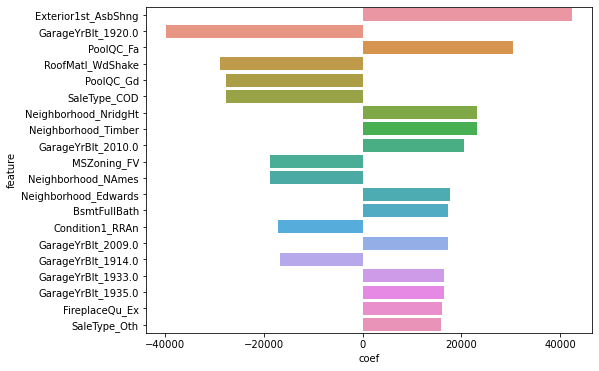

In [33]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x='coef', y='feature', data=ft_imps.iloc[:20, :])

In [34]:
print(f"Number of redundant features: {ft_imps[ft_imps['coef'] == 0].shape}")

Number of redundant features: (1, 2)


### Evaluation

In [35]:
# get training prediction
y_train_pred = best_model.predict(X_train)

# get test prediction
y_test_pred = best_model.predict(X_test)


print(f"Training R2 Score: {r2_score(y_train, y_train_pred):.2%}")
print(f"Training RMSE Score: {mean_squared_error(y_train, y_train_pred)**0.5:,.0}")

print(f"Testing R2 Score: {r2_score(y_test, y_test_pred):.2%}")
print(f"Testing RMSE Score: {mean_squared_error(y_test, y_test_pred)**0.5:,.0}")

Training R2 Score: 94.66%
Training RMSE Score: 2e+04
Testing R2 Score: 87.76%
Testing RMSE Score: 3e+04


### Check Residuals

C:\Users\prate\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


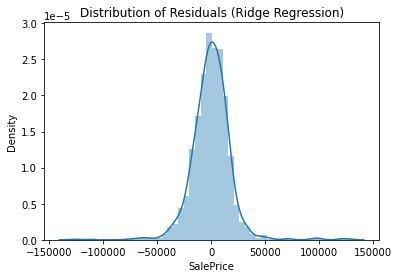

In [36]:
residuals = (y_train - y_train_pred)
sns.distplot(residuals)
plt.title("Distribution of Residuals (Ridge Regression)")
plt.show()

Text(0.5, 1.0, 'Predicted vs. Residuals')

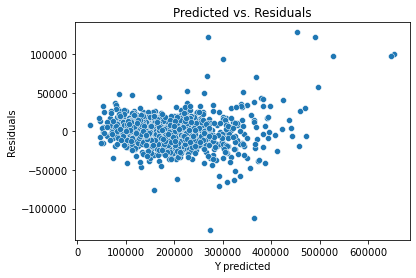

In [37]:
sns.scatterplot(x=y_train_pred, y=residuals)
plt.xlabel('Y predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs. Residuals')

### Double the lamda and refit

In [38]:
print("Current best alpha value: ", best_model.named_steps['reg'].alpha)

Current best alpha value:  1


In [39]:
best_model.named_steps['reg'].alpha *=2 
print("Updated best alpha value: ", best_model.named_steps['reg'].alpha)

Updated best alpha value:  2


In [40]:
# refit the model
best_model.fit(X_train, y_train)

# get training prediction
y_train_pred = best_model.predict(X_train)

# get test prediction
y_test_pred = best_model.predict(X_test)


print(f"Training R2 Score: {r2_score(y_train, y_train_pred):.2%}")
print(f"Training RMSE Score: {mean_squared_error(y_train, y_train_pred)**0.5:,.0}")

print(f"Testing R2 Score: {r2_score(y_test, y_test_pred):.2%}")
print(f"Testing RMSE Score: {mean_squared_error(y_test, y_test_pred)**0.5:,.0}")

Training R2 Score: 94.50%
Training RMSE Score: 2e+04
Testing R2 Score: 87.81%
Testing RMSE Score: 3e+04


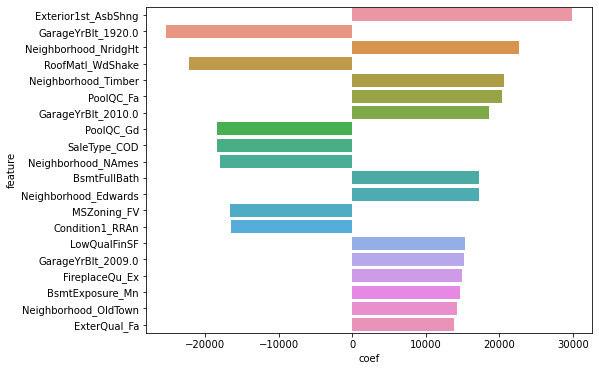

In [41]:
# get the model
reg_model = best_model.named_steps['reg']

ft_imps = get_feature_importances(reg_model, all_feature_names)

fig = plt.figure(figsize=(8, 6))
sns.barplot(x='coef', y='feature', data=ft_imps.iloc[:20, :])

### Observations:
+ Best value of alpha was 1
+ Updated value of alpha was 2, upon doubling
+ On refiting with alpha=2, had no impact on the models performance

# Lasso Regression

In [42]:
lasso_model_pipeline = get_model_pipeline(numeric_cols, cat_cols, model=Lasso())

In [43]:
grid_params = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'reg__alpha': [0, .2, .4, .6, .8, 1],
    'reg__fit_intercept': [True]
}

In [44]:
lasso_gsh = GridSearchCV(estimator=lasso_model_pipeline, param_grid=grid_params, cv=5, n_jobs=4)
lasso_gsh.fit(X_train, y_train)

C:\Users\prate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16850258226.724365, tolerance: 802526119.0575445
  model = cd_fast.sparse_enet_coordinate_descent(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'L...
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'Gar

In [45]:
lasso_gsh_results = pd.DataFrame(lasso_gsh.cv_results_)
lasso_gsh_results.sort_values('rank_test_score', ascending=True, inplace=True)
lasso_gsh_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__poly__degree,param_reg__alpha,param_reg__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.438259,0.063270,0.015841,0.003134,1,1,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 1, 'reg__fit_intercept': True}",0.796593,0.857805,0.882961,0.828891,0.900187,0.853287,0.037175,1
4,1.426624,0.046940,0.014842,0.000946,1,0.8,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.8, 'reg__fit_intercept': True}",0.795585,0.857051,0.882000,0.827246,0.899143,0.852205,0.037264,2
3,1.400013,0.039931,0.015172,0.001497,1,0.6,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.6, 'reg__fit_intercept': True}",0.794647,0.856302,0.880871,0.825591,0.897842,0.851051,0.037245,3
2,1.447947,0.098311,0.016348,0.001064,1,0.4,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.4, 'reg__fit_intercept': True}",0.793472,0.855549,0.879730,0.823925,0.896335,0.849802,0.037247,4
1,1.450329,0.108949,0.017418,0.002873,1,0.2,True,"{'preprocessor__num__poly__degree': 1, 'reg__alpha': 0.2, 'reg__fit_intercept': True}",0.792805,0.854569,0.878435,0.822087,0.894516,0.848483,0.037014,5


### Lasso Model Inferencing

In [46]:
# get the best estimator
best_model = lasso_gsh.best_estimator_

# get the best model parameters
best_model_params = lasso_gsh.best_params_
best_model_params

{'preprocessor__num__poly__degree': 1,
 'reg__alpha': 1,
 'reg__fit_intercept': True}

### Lasso Feature Importance

In [47]:
# get the model
lasso_model = best_model.named_steps['reg']

cat_encoder = best_model.named_steps['preprocessor'].transformers_[1][1]
cat_feature_names = get_encoded_feature_names(cat_cols, cat_encoder)
print(f"Number of final categorical features: {len(cat_feature_names)}")

# get all feature names
all_feature_names = get_all_feature_names(numeric_cols, cat_cols, cat_encoder)
print(f"Number of final features: {len(all_feature_names)}")

Number of final categorical features: 374
Number of final features: 408


In [48]:
lasso_orig_ft_imps = get_feature_importances(lasso_model, all_feature_names)
lasso_orig_ft_imps.head(5)

,feature,coef
0,PoolQC_Gd,-196798.973473
1,PoolQC_NA,-142506.240039
2,GarageYrBlt_1920.0,-115594.478679
3,Condition2_RRAn,-103816.191936
4,Exterior1st_AsbShng,85648.263255


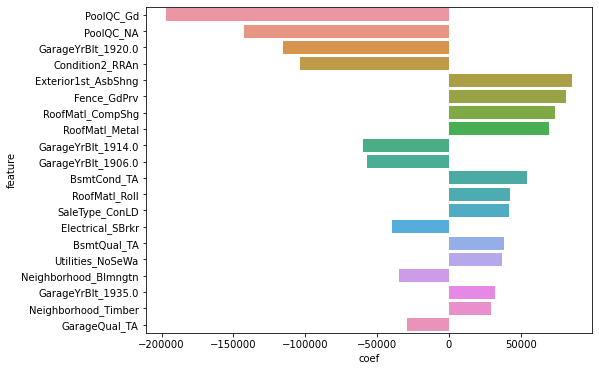

In [49]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x='coef', y='feature', data=lasso_orig_ft_imps.iloc[:20, :])

### Lasso Model Evaluation

In [50]:
# get training prediction
y_train_pred = best_model.predict(X_train)

# get test prediction
y_test_pred = best_model.predict(X_test)


print(f"Training R2 Score: {r2_score(y_train, y_train_pred):.2%}")
print(f"Training RMSE Score: {mean_squared_error(y_train, y_train_pred)**0.5:,.0}")

print(f"Testing R2 Score: {r2_score(y_test, y_test_pred):.2%}")
print(f"Testing RMSE Score: {mean_squared_error(y_test, y_test_pred)**0.5:,.0}")

Training R2 Score: 94.96%
Training RMSE Score: 2e+04
Testing R2 Score: 86.26%
Testing RMSE Score: 3e+04


### Check Residuals

C:\Users\prate\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


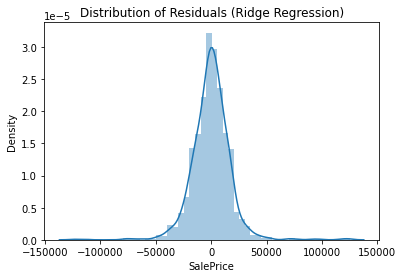

In [51]:
residuals = (y_train - y_train_pred)
sns.distplot(residuals)
plt.title("Distribution of Residuals (Ridge Regression)")
plt.show()

Text(0.5, 1.0, 'Predicted vs. Residuals')

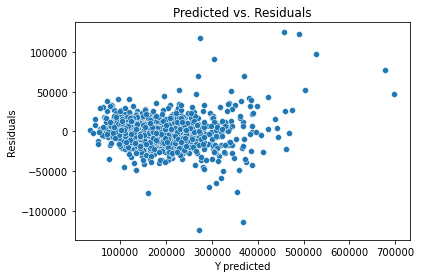

In [52]:
sns.scatterplot(x=y_train_pred, y=residuals)
plt.xlabel('Y predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs. Residuals')

### Double the lamda and refit

In [53]:
print("Current best alpha value: ", best_model.named_steps['reg'].alpha)

Current best alpha value:  1


In [54]:
best_model.named_steps['reg'].alpha *=2 
print("Updated best alpha value: ", best_model.named_steps['reg'].alpha)

Updated best alpha value:  2


In [55]:
# refit the model
best_model.fit(X_train, y_train)

# get training prediction
y_train_pred = best_model.predict(X_train)

# get test prediction
y_test_pred = best_model.predict(X_test)


print(f"Training R2 Score: {r2_score(y_train, y_train_pred):.2%}")
print(f"Training RMSE Score: {mean_squared_error(y_train, y_train_pred)**0.5:,.0}")

print(f"Testing R2 Score: {r2_score(y_test, y_test_pred):.2%}")
print(f"Testing RMSE Score: {mean_squared_error(y_test, y_test_pred)**0.5:,.0}")

Training R2 Score: 94.95%
Training RMSE Score: 2e+04
Testing R2 Score: 86.60%
Testing RMSE Score: 3e+04


C:\Users\prate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4181202635.6730957, tolerance: 802526119.0575445
  model = cd_fast.sparse_enet_coordinate_descent(


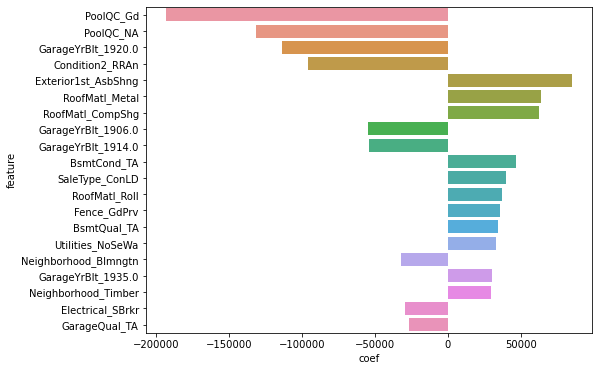

In [56]:
# get the model
lasso_model = best_model.named_steps['reg']

ft_imps = get_feature_importances(lasso_model, all_feature_names)

fig = plt.figure(figsize=(8, 6))
sns.barplot(x='coef', y='feature', data=ft_imps.iloc[:20, :])

### Observations:
+ Best value of alpha was 1
+ Updated value of alpha was 2, upon doubling
+ On refiting with alpha=2, had no impact on the models performance

## Top Lasso Features

They are based on LotFrontage and Neighborhood

In [57]:
lasso_orig_ft_imps.head(10)

,feature,coef
0,PoolQC_Gd,-196798.973473
1,PoolQC_NA,-142506.240039
2,GarageYrBlt_1920.0,-115594.478679
3,Condition2_RRAn,-103816.191936
4,Exterior1st_AsbShng,85648.263255
5,Fence_GdPrv,81477.800136
6,RoofMatl_CompShg,74050.652364
7,RoofMatl_Metal,69733.649361
8,GarageYrBlt_1914.0,-59709.039922
9,GarageYrBlt_1906.0,-56933.191749


In [58]:
print(f"Number of redundant features: {lasso_orig_ft_imps[lasso_orig_ft_imps['coef'] == 0].shape}")

Number of redundant features: (38, 2)


## Refit Lasso model after excluding LotFrontage and Neighborhood

In [65]:
updt_cat_cols = [col for col in cat_cols if col not in ['PoolQC', 'GarageYrBlt', 'Condition2', 'Exterior1st', 'Fence']]
print(updt_cat_cols)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']


In [66]:
# get the pipeline with excluded features
lasso_model_pipeline = get_model_pipeline(numeric_cols, updt_cat_cols, model=Lasso())

# fit via grid search
lasso_gsh = GridSearchCV(estimator=lasso_model_pipeline, param_grid=grid_params, cv=5, n_jobs=4)
lasso_gsh.fit(X_train, y_train)
pass

C:\Users\prate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8921005631.933289, tolerance: 802526119.0575445
  model = cd_fast.sparse_enet_coordinate_descent(


In [67]:
# get the best estimator
best_model = lasso_gsh.best_estimator_

# get the best model parameters
best_model_params = lasso_gsh.best_params_
best_model_params

{'preprocessor__num__poly__degree': 1,
 'reg__alpha': 1,
 'reg__fit_intercept': True}

In [68]:
# get the model
lasso_model = best_model.named_steps['reg']

cat_encoder = best_model.named_steps['preprocessor'].transformers_[1][1]
cat_feature_names = get_encoded_feature_names(updt_cat_cols, cat_encoder)
print(f"Number of final categorical features: {len(cat_feature_names)}")

# get all feature names
all_feature_names = get_all_feature_names(numeric_cols, updt_cat_cols, cat_encoder)
print(f"Number of final features: {len(all_feature_names)}")

Number of final categorical features: 248
Number of final features: 282


In [69]:
ft_imps = get_feature_importances(reg_model, all_feature_names)
ft_imps.head(10)

,feature,coef
0,Exterior2nd_ImStucc,29875.135043
1,SaleType_ConLI,-25335.250467
2,Neighborhood_NridgHt,22720.790590
3,Exterior2nd_CmentBd,-22296.079004
4,Neighborhood_Timber,20590.750912
5,Neighborhood_NAmes,-17980.657339
6,BsmtFullBath,17218.752187
7,Neighborhood_Edwards,17202.565866
8,MSZoning_FV,-16716.946326
9,Condition1_RRAn,-16530.840863


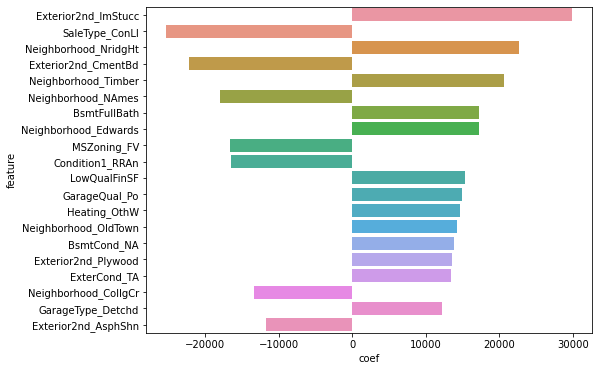

In [70]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x='coef', y='feature', data=ft_imps.iloc[:20, :])

# Observations from Lasso Model

> Some of the most influential factors:
+ **PoolQC_Gd** impact price negatively, i.e. if Pool quality is good then prices are lower, may be people expect quality to be excellent
+ **PoolQC_NA** also impact price negatively, i.e. prices are lower inabsence of Pool
+ **GarageYrBlt_1920** when garage is older then the prices are lower as well
+ **Condition2_RRAn** leads to lower house prices, since the properties are adjacent to Railroads
+ **Exterior1st** with **"Asbestos Shingles"** covering house has positive impact on house prices
+ **Fence_GdPrv** when Fence is good quality with better privacy - then the prices are higher